## Traveling Salesman Problem - Optimization

### Import Packages

In [1]:
from pyomo.environ import *
import pyomo.environ as pyo
import random
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

### Inputs

In [2]:
#Generate Data Inputs

# Select random seed
random.seed(1)

# Number of cities
n=50

#Coordinate Range
rangelct=10000

#Generate random locations
coordlct_x = random.choices(range(0, rangelct), k=n)
coordlct_y = random.choices(range(0, rangelct), k=n)

#Compute distance between locations
distancelct=np.empty([n, n])
for i_index in range(n):
    for j_index in range(n):
        distancelct[i_index,j_index]=(math.sqrt(((coordlct_x[i_index]-coordlct_x[j_index])**2) +((coordlct_y[i_index]-coordlct_y[j_index])**2)))    

distancelct[np.diag_indices_from(distancelct)] = 99999

df = pd.DataFrame(distancelct)
df.index += 1
df.columns += 1
cij_model=df.stack().to_dict()


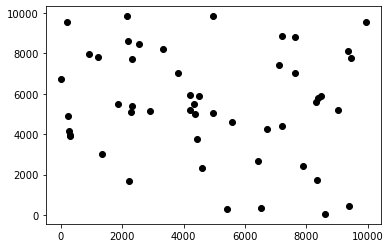

In [3]:
plt.plot(coordlct_x, coordlct_y, 'o', color='black');

### Sets

In [4]:
# Create Model
model = AbstractModel()

# Set of cities to visit
model.N = RangeSet(n)
model.U= RangeSet(2,n)

### Parameters

In [5]:
# c[i,j] - distance from i and j
model.c = Param(model.N, model.N, initialize=cij_model)

### Decision Variables

In [6]:
# x[i,j] - 1 if city j is visited right after city i, 0 otherwise
model.x = Var(model.N, model.N, within=Binary)

# u[i] - auxiliary variable indicating tour ordering
model.u = Var(model.N, within=Integers,bounds=(0,n))

### Objective Function

In [7]:
# Minimize total distance
def cost_(model):
    return sum(model.c[i,j]*model.x[i,j] for i in model.N for j in model.N)
model.cost = Objective(rule=cost_)

### Constraints

In [8]:
#  There is only one departure from each city
def arrive_(model, j):
    return sum(model.x[i,j] for i in model.N if i!=j ) == 1
model.arrive = Constraint(model.N, rule=arrive_)

In [9]:
# There is only one arrival to each city
def depart_(model, i):
    return sum(model.x[i,j] for j in model.N if j!=i ) == 1
model.depart = Constraint(model.N, rule=depart_)

In [10]:
#  There is only a single tour covering all cities, and not two or more disjointed tours
def singletour_(model,i,j):
    if i!=j: 
        return model.u[i] - model.u[j] + model.x[i,j] * n <= n-1
    else:
        return model.u[i] - model.u[j] == 0 
    
model.singletour = Constraint(model.U,model.N,rule=singletour_)

### Solve Model

In [11]:
instance = model.create_instance()
opt = pyo.SolverFactory('gurobi')
opt.solve(instance, options={'TimeLimit': 3600*500},tee=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-11-27
Read LP format model from file C:\Users\NUNORI~1\AppData\Local\Temp\tmpchbnotjx.pyomo.lp
Reading time = 0.04 seconds
x2551: 2551 rows, 2551 columns, 12104 nonzeros
Set parameter TimeLimit to value 1800000
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2551 rows, 2551 columns and 12104 nonzeros
Model fingerprint: 0x3cfa814e
Variable types: 1 continuous, 2550 integer (2500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [2e+01, 1e+05]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 50 rows and 52 columns
Presolve time: 0.01s
Presolved: 2501 rows, 2499 columns, 12054 nonzeros
Variable types: 0 continuous, 2499 integer (2450 binary)
Found heuristic solution: objective 257923.09423

Root relaxation: objective 4.599982e+04, 1

{'Problem': [{'Name': 'x2551', 'Lower bound': 57546.07725865518, 'Upper bound': 57546.07725865518, 'Number of objectives': 1, 'Number of constraints': 2551, 'Number of variables': 2551, 'Number of binary variables': 2500, 'Number of integer variables': 2550, 'Number of continuous variables': 1, 'Number of nonzeros': 12104, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '42.155805587768555', 'Error rc': 0, 'Time': 42.48156547546387}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### Read output variables

In [17]:
xij_dic = {i:int(np.round(pyo.value(j))) for (i,j) in instance.x.items()}
xij = pd.DataFrame(xij_dic.values(), index = xij_dic.keys()).unstack()
linkindex = np.where(xij == 1)

In [18]:
ui_dic = {i:int(np.round(pyo.value(j))) for (i,j) in instance.u.items()}
ui = pd.DataFrame(ui_dic.values(), index = ui_dic.keys()).unstack()
sequence = np.where(ui == 1)
uidf=pd.DataFrame(ui)
uidf=uidf.sort_values(by=[0])

pd.set_option('display.max_rows', uidf.shape[0]+1)


### Plot results

50

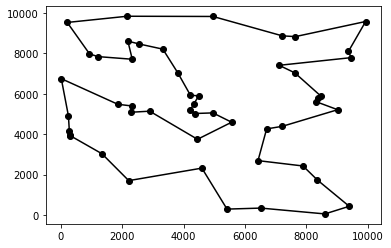

In [19]:
def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'k-')

for i_index in range(len(linkindex[0])): 
    connectpoints(coordlct_x,coordlct_y,linkindex[0][i_index],linkindex[1][i_index])
    
plt.plot(coordlct_x, coordlct_y, 'o', color='black');
len(linkindex[0])